# CAPM Factor model estimation
## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import datetime as dt

from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../')

import src

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
sys.path.append('../../kungfu/')
import kungfu as kf

## Process all years

In [51]:
df_factor_model = pd.DataFrame()
for year in range(1994, 2020):
    # estimate
    if year == 2019:
        df_estimates = src.factor.idiosyncratic_vola(year, steps=1)
    else:
        df_estimates = src.factor.idiosyncratic_vola(year, steps=2)
    df_estimates.index = pd.MultiIndex.from_product([[year], df_estimates.index], names=['sampling_year', 'permno'])
    
    # collect
    df_factor_model = df_factor_model.append(df_estimates)
    
    # progress
    print('processed sampling year {}'.format(year))
    
df_factor_model.to_csv('../data/estimated/factor_models.csv')

processed sampling year 1994
processed sampling year 1995
processed sampling year 1996
processed sampling year 1997
processed sampling year 1998
processed sampling year 1999
processed sampling year 2000
processed sampling year 2001
processed sampling year 2002
processed sampling year 2003
processed sampling year 2004
processed sampling year 2005
processed sampling year 2006
processed sampling year 2007
processed sampling year 2008
processed sampling year 2009
processed sampling year 2010
processed sampling year 2011
processed sampling year 2012
processed sampling year 2013
processed sampling year 2014
processed sampling year 2015
processed sampling year 2016
processed sampling year 2017
processed sampling year 2018
processed sampling year 2019


In [ ]:
from sklearn.decomposition import FactorAnalysis

In [40]:
def build_factor_model_residuals(year):
    # load
    df_returns = src.loader.load_year(year, data='returns', data_year=year).fillna(0)
    df_vola = src.loader.load_year(year, data='volas', data_year=year)
    df_idio = src.loader.load_year(year, data='idio_vola', data_year=year)
    rf = src.loader.load_rf(year)
    ff = src.loader.load_factors(year)

    # estimate factor models
    mm_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), ff[['mktrf']])
    ff3_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), ff[['mktrf', 'smb', 'hml']])
    c4_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), ff[['mktrf', 'smb', 'hml', 'umd']])

    fam = FactorAnalysis(n_components=5).fit(df_returns.T)
    facs = pd.DataFrame(fam.components_).T
    fam_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), facs)

    # construct residuals
    mm_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(ff[['mktrf']]) @ mm_estimates.T
    ff3_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(ff[['mktrf', 'smb', 'hml']]) @ ff3_estimates.T
    c4_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(ff[['mktrf', 'smb', 'hml', 'umd']]) @ c4_estimates.T
    fam_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(pd.DataFrame(index=ff.index, data=facs.values)) @ fam_estimates.T

    # save matrices
    mm_residuals.to_csv('../data/processed/annual/{}/mm_residuals_{}.csv'.format(year, year))
    ff3_residuals.to_csv('../data/processed/annual/{}/ff3_residuals_{}.csv'.format(year, year))
    c4_residuals.to_csv('../data/processed/annual/{}/c4_residuals_{}.csv'.format(year, year))
    fam_residuals.to_csv('../data/processed/annual/{}/fam_residuals_{}.csv'.format(year, year))

In [42]:
for year in range(1994, 2020):
    build_factor_model_residuals(year)
    print('Done building year {}'.format(year))

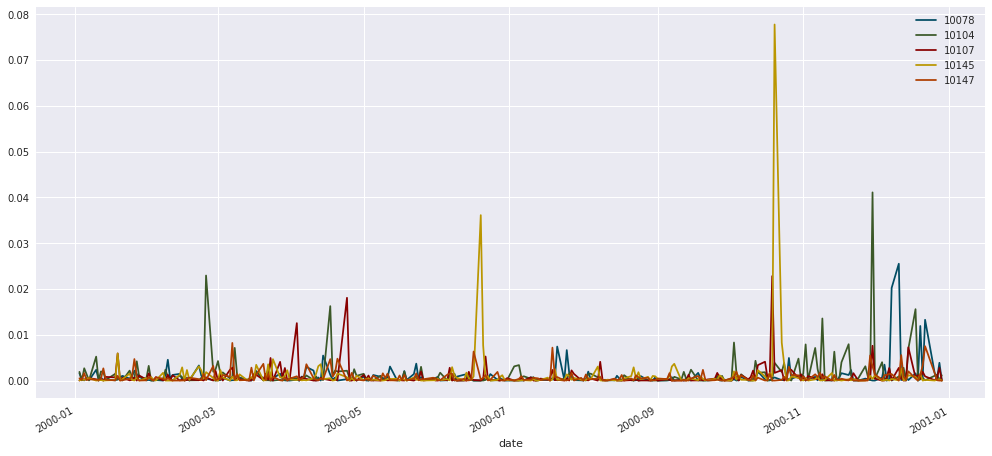

In [29]:
(ff3_epsilons**2).iloc[:,0:5].plot()

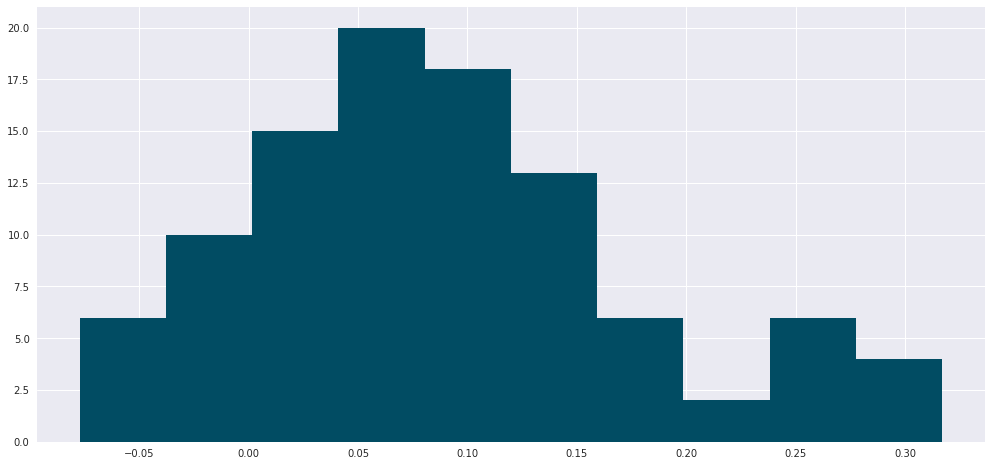

In [15]:
pd.Series(np.diag(src.utils.autocorrcoef((mm_epsilons**2)))).hist()

In [16]:

_ = FactorAnalysis(n_components=5).fit(df_returns.T)
facs = pd.DataFrame(_.components_).T

In [17]:
year = 2000
df_returns = src.loader.load_year(year, data='returns', data_year=year)
df_vola = src.loader.load_year(year, data='volas', data_year=year)
df_idio = src.loader.load_year(year, data='idio_vola', data_year=year)
rf = src.loader.load_rf(year)
ff = src.loader.load_factors(year)
estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), facs)

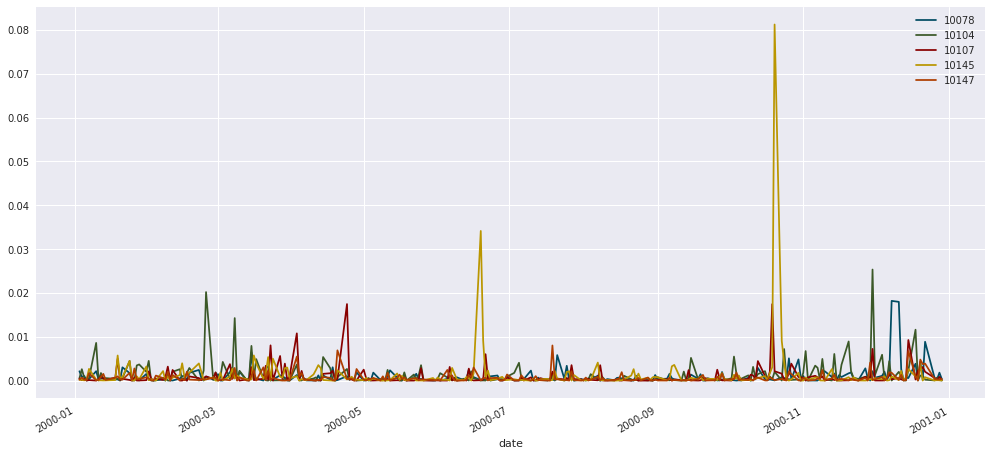

In [18]:
epsilons = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(pd.DataFrame(index=ff.index, data=facs.values)) @ estimates.T
(epsilons**2).iloc[:,0:5].plot()

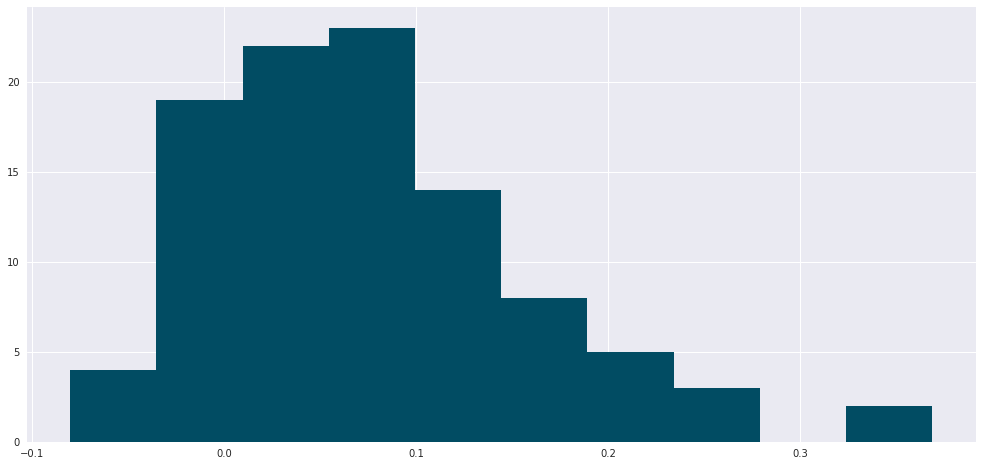

In [19]:
pd.Series(np.diag(src.utils.autocorrcoef((epsilons**2)))).hist()

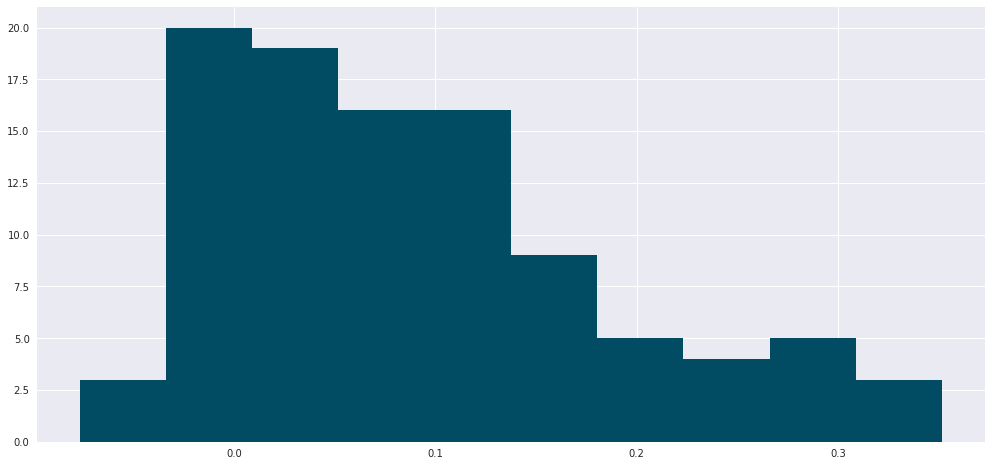

In [107]:
pd.Series(np.diag(src.utils.autocorrcoef((df_returns**2)))).hist()

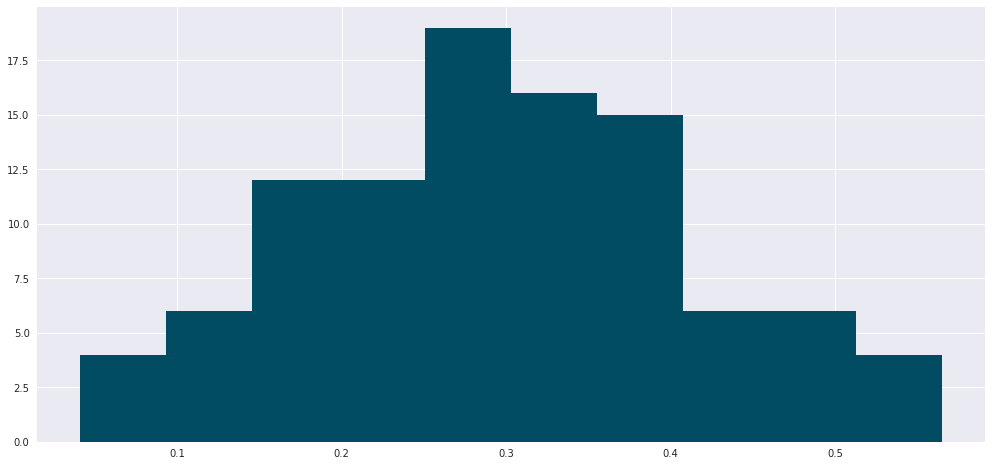

In [105]:
pd.Series(np.diag(src.utils.autocorrcoef((df_vola)))).hist()

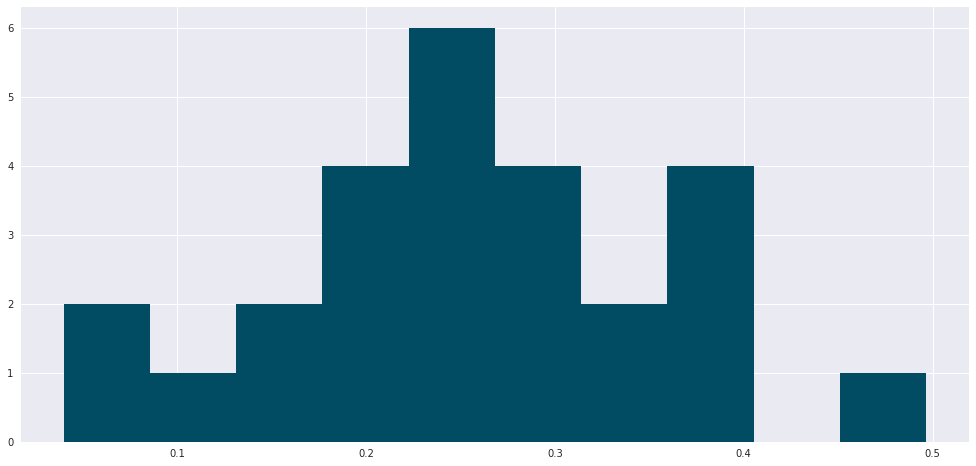

In [106]:
pd.Series(np.diag(src.utils.autocorrcoef((df_idio)))).hist()

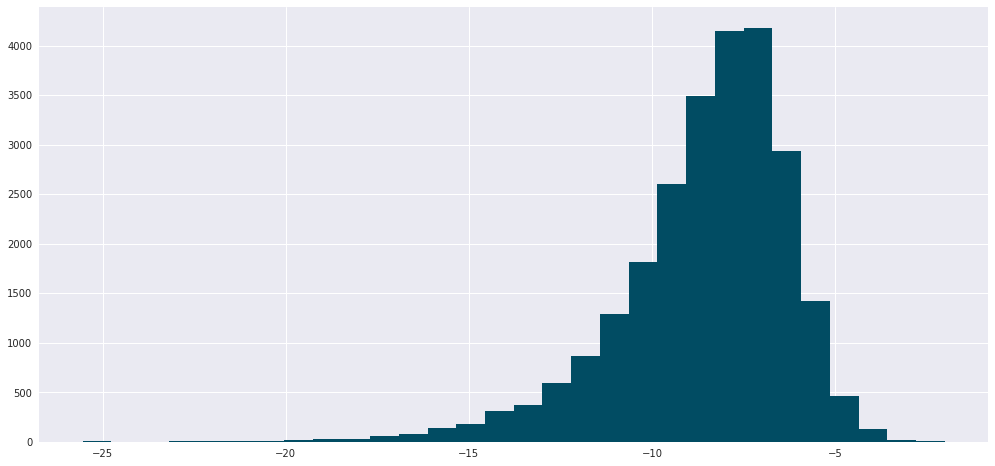

In [25]:
np.log((mm_epsilons**2)).stack().hist(bins=30)

## Single year analysis
### Load data

In [37]:
year = 2019

In [5]:
df_returns = src.loader.load_year(year, data='returns')
df_volas = src.loader.load_year(year, data='volas')
df_spy_ret = src.loader.load_spy_returns(year)
df_spy_vola = src.loader.load_spy_vola(year)
rf = src.loader.load_rf(year)
tickers = src.loader.load_year_tickers(year)

In [39]:
returns, factors = df_returns, df_spy_ret
estimates = src.preprocess.estimate_factor_model(returns.subtract(rf.values), factors.subtract(rf.values))

volas, betas, factor_vola = df_volas, estimates['beta'], df_spy_vola
src.preprocess.decompose_vola(volas, betas, factor_vola)

,10104,10107,10145,10696,11308,11850,12060,12308,12490,13407,...,89626,90215,90319,91233,91937,92602,92611,92655,93002,93436
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,0.001613,NaN,0.001345,0.002718,0.008497,0.024574,0.008694,0.007811,0.016117,...,0.003800,0.002058,0.005466,0.002896,0.010586,0.007104,0.005780,0.003393,0.003024,0.011830
2019-01-03,0.003096,0.004161,0.005488,0.004989,0.004047,0.005212,0.011572,0.007595,NaN,0.009777,...,0.008932,0.006438,0.008765,0.006419,0.007611,0.006859,0.004107,0.007077,0.016061,0.007758
2019-01-04,0.007019,0.004695,NaN,0.006579,0.004341,0.004058,0.002001,0.013805,0.001482,0.002370,...,0.005404,0.011146,0.007164,0.005150,0.006408,0.009174,0.005879,0.002368,NaN,0.009920
2019-01-07,0.007729,0.001491,0.002976,0.004082,0.004287,0.002796,0.013962,0.002778,0.000694,0.001064,...,0.003001,0.006435,NaN,NaN,0.005234,0.006926,0.003863,0.002589,0.008368,0.014002
2019-01-08,0.005219,0.003709,0.003371,0.005292,0.002534,NaN,0.014855,0.004175,NaN,0.005101,...,0.006704,0.004797,0.004249,0.003335,0.004358,0.001993,0.002309,0.004902,0.007986,0.012442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.002892,0.000741,0.001568,0.002182,0.001698,0.002140,0.002474,0.001406,0.001872,0.002177,...,0.002864,0.001405,0.001377,0.001354,0.001614,0.001757,0.001450,0.001976,0.001150,0.007929
2019-12-26,0.001473,0.001716,0.001333,0.002548,0.000984,0.001524,0.001786,0.003267,0.000539,0.002874,...,0.002571,0.001486,0.003130,0.000204,0.000109,0.002954,0.001717,0.001314,0.003714,0.004095
2019-12-27,0.001821,0.001503,0.000513,0.004131,0.002029,0.001124,0.000686,0.002899,0.001056,0.002501,...,0.003473,0.001917,0.002204,0.002453,0.001383,0.001801,0.001460,0.001016,0.002892,0.005333


### Compare zero innovation frequency for CAPM regression vs. Variance regression

In [8]:
def idiosyncratic_vola(year, steps=2):
    ''''''
    # setup
    index = src.loader.load_year(year, data='returns').columns
    df_estimates = pd.DataFrame(index=index)
    
    for step in range(steps):
        # load
        df_returns = src.loader.load_year(year, data='returns', data_year=year+step)
        df_volas = src.loader.load_year(year, data='volas', data_year=year+step)
        df_spy_ret = src.loader.load_spy_returns(year+step)
        df_spy_vola = src.loader.load_spy_vola(year+step)

        # estimate
        estimates = estimate_factor_model(df_returns, df_spy_ret)
        vola_estimates = estimate_factor_model(df_volas**2, df_spy_vola**2)
    
        # decompose
        idio_vola = decompose_vola(df_volas, estimates['beta'], df_spy_vola)
        idio_vola_direct = decompose_vola(df_volas, estimates['beta']**0.5, df_spy_vola)
    
    return idio_vola, idio_vola_direct

In [19]:
zero_count = pd.DataFrame(index=np.arange(1994, 2020), columns=['CAPM regression', 'Variance regression'])
for year in range(1994, 2020):
    CAPM, VOLA = idiosyncratic_vola(year, 1)
    zeros_CAPM = (CAPM==0).values.sum()
    zeros_VOLA = (VOLA==0).values.sum()
    zero_count.loc[year, 'CAPM regression'] = zeros_CAPM
    zero_count.loc[year, 'Variance regression'] = zeros_VOLA

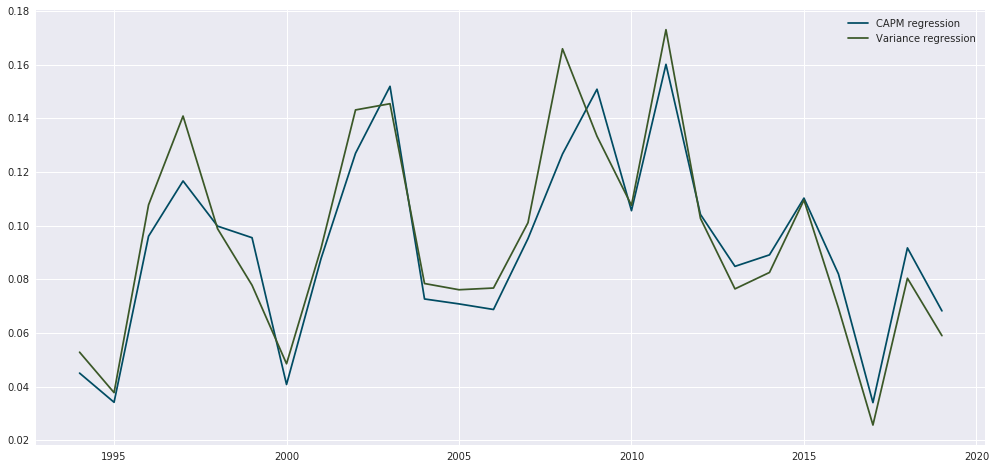

In [18]:
(zero_count/(250*100)).plot()

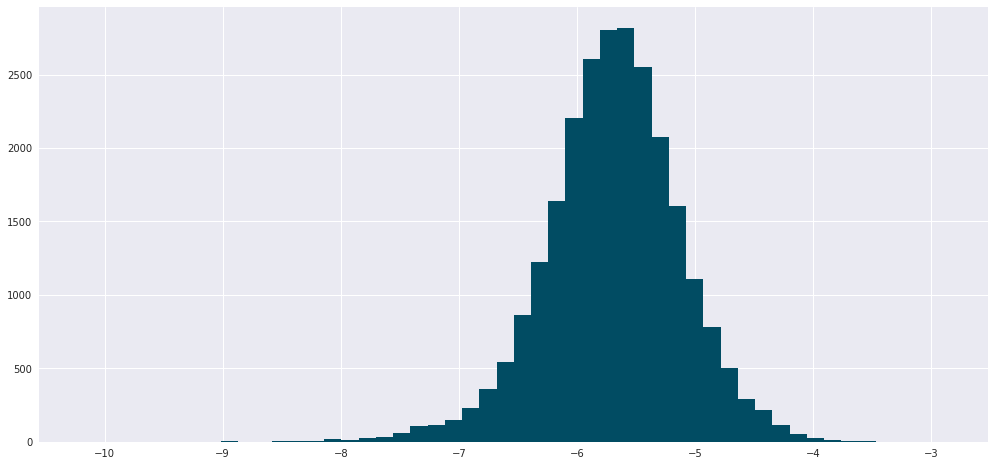

In [43]:
np.log(CAPM.stack().replace(0, np.nan).ffill().fillna(CAPM.stack().mean())).hist(bins=50)

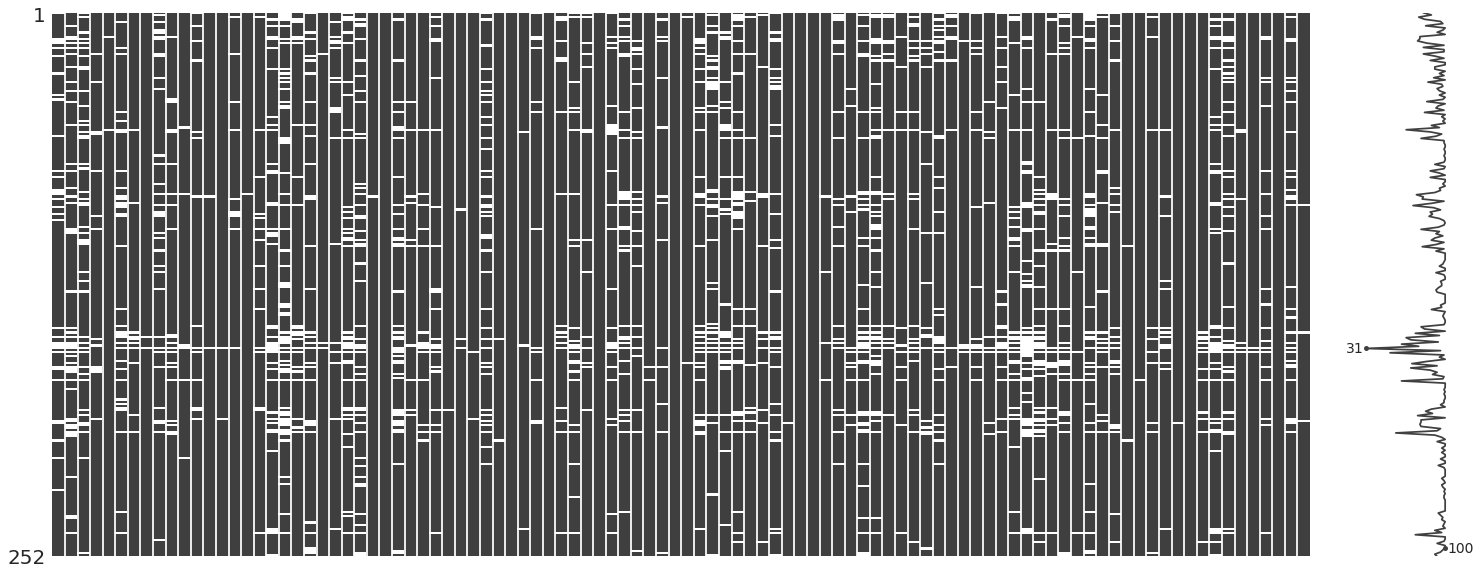

In [27]:
missingno.matrix(CAPM.replace(0, np.nan))

In [308]:
df_factor_model.corr()

,alpha,beta,alpha_t+1,beta_t+1
alpha,1.000000,0.005645,0.024687,0.000168
beta,0.005645,1.000000,0.032458,0.707052
alpha_t+1,0.024687,0.032458,1.000000,0.062269
beta_t+1,0.000168,0.707052,0.062269,1.000000


In [155]:
estimate_factor_model(df_volas, df_spy_vola).join(estimate_factor_model(df_returns, df_spy_ret), lsuffix='vola').corr()

,αvola,βvola,α,β
αvola,1.000000,0.029866,0.017806,0.316932
βvola,0.029866,1.000000,0.248434,0.883714
α,0.017806,0.248434,1.000000,0.228037
β,0.316932,0.883714,0.228037,1.000000


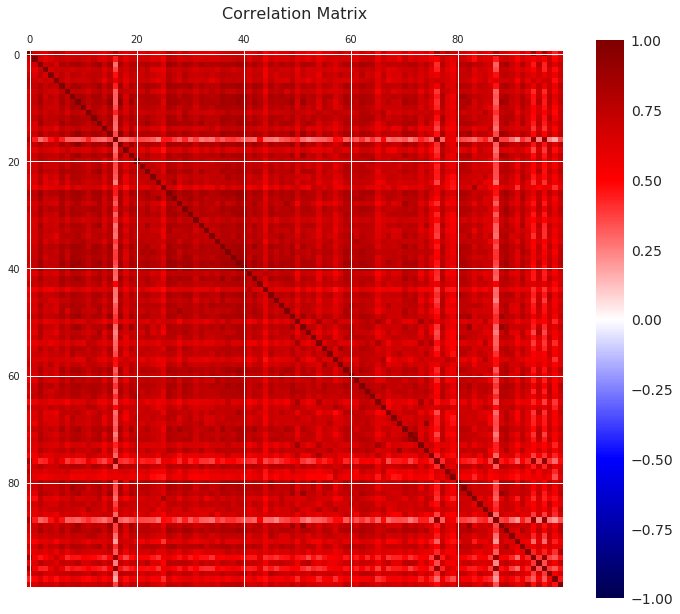

In [310]:
src.plot.corr_heatmap(df_volas.corr())

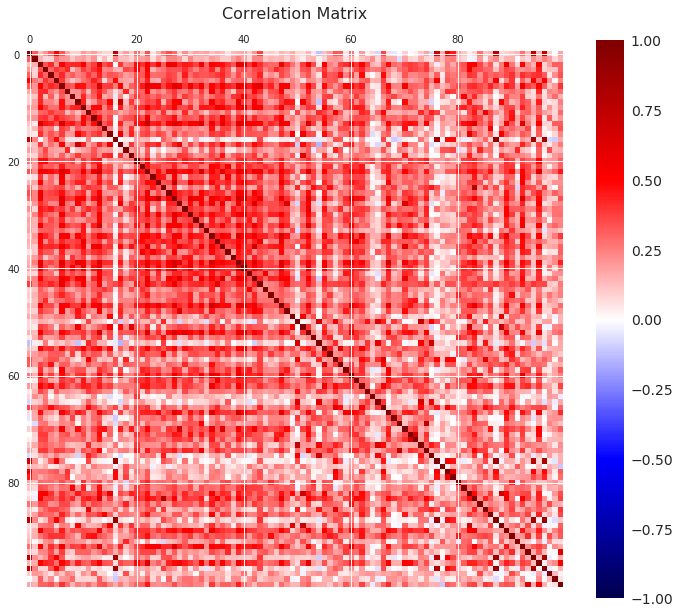

In [158]:
src.plot.corr_heatmap(idio_vola.corr())

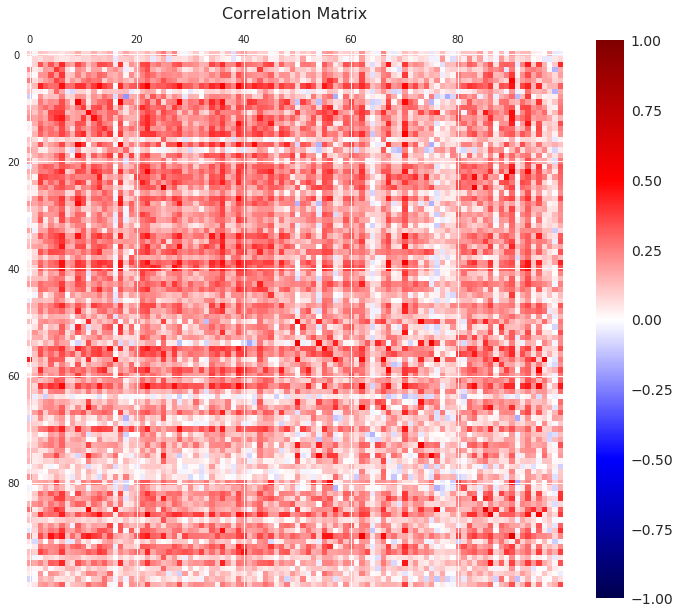

In [159]:
src.plot.corr_heatmap(src.utils.autocorrcoef(idio_vola))